# การทำความเข้าใจข้อมูลและการเตรียมข้อมูล (Data Understanding and Preprocessing)

In [ ]:
from sklearn.pipeline import Pipeline
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer


In [ ]:
#โหลดข้อมูลเครดิตจาก UCI และทำการสำรวจเบื้องต้น
# https://archive.ics.uci.edu/dataset/28/japanese+credit+screening
data_path='https://archive.ics.uci.edu/ml/machine-learning-databases/credit-screening/crx.data'
data=pd.read_csv(data_path,names=['A'+str(i) for i in range(1,17)])


In [ ]:
# ติดตั้งแพ็คเกจเพื่อให้การวิเคราะห์ข้อมูลเบื้องต้นง่ายขึ้น
# https://pub.towardsai.net/5-python-packages-for-effortless-eda-94abddac3bc5
!pip install jupyter-summarytools --quiet

## ทำความเข้าใจข้อมูล

In [ ]:
from summarytools import dfSummary

In [ ]:
dfSummary(data)

No,Variable,Stats / Values,Freqs / (% of Valid),Graph,Missing
1,A1[object],1. b2. a3. ?,468 (67.8%)210 (30.4%)12 (1.7%),"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAABFCAYAAABdVZTTAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjcuMSwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/bCgiHAAAACXBIWXMAAA9hAAAPYQGoP6dpAAABqUlEQVR4nO3bPWrDQBRF4ScjTNyMEAItZhaRxWYR2o0QmiIybpQiTsif0zi6kzc6X5fuQY5tZHyrdV0NUDjkPgD7UZnZycyOuQ/Bry7rui65j7hX3XXdYwihzX0IbkspTVVVPXkPrg4htDHGpWmac+5j8N08zw/DMLTjOB7NzHdsZmZN05z7vn/OfQxuOuU+4C/wgAAZYoMMsUGG2CBDbJAhNsgQG2SIDTLEBhligwyxQYbYIENskCE2yNRmr7+Zyn0IflbS/6ZOKU3DMLRWyG+mSpRSmszskvuOe7FB8KGIDULFlA8q3t/ZinjF74XrdVUpq6O9cLuuKml1tBfe11U8QTvCl7qQITbIEBtkiA0yxAYZYoMMsUGG2CBDbJAhNsgQG2SIDTLEBhlig4zbdZXHm/fO9bqqlNXRXrBBgAzrKsjwgACZrx+jfCxhM5+mfEzjsKXD25Qvxrhco/P6sIB/7n3Kd/3b3dcf8IMHBMgQG2SIDTLEBhligwyxQYbYIENskCE2yBAbZIgNMsQGGWKDDLFBxu2UD/58nPIxjcOm2CBAhikfZF4A416W61E6oaMAAAAASUVORK5CYII="">",0(0.0%)
2,A2[object],1. ?2. 22.673. 20.424. 18.835. 24.506. 25.007. 19.178. 22.509. 20.6710. 23.5811. other,12 (1.7%)9 (1.3%)7 (1.0%)6 (0.9%)6 (0.9%)6 (0.9%)6 (0.9%)6 (0.9%)6 (0.9%)6 (0.9%)620 (89.9%),"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAAD+CAYAAAAtWHdlAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjcuMSwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/bCgiHAAAACXBIWXMAAA9hAAAPYQGoP6dpAAAD8UlEQVR4nO3cTW4iVwBG0QdCTjMphJC8DC+ARXixWQQL8D4sixoExxNnELrVo/zY5hKRc2YeWHqDqwKX3ufF+/v7gMLy2gfg/0NsZMRGRmxkxEZGbGTERkZsZMRGZjHGWI8x7s4/v72/v5+ueB5u2Gq32z1O07QdY4x5nl8Wi8WvguMSltM0bff7/Wm/35/O0d397W/BB6zGGGOz2byef15f8SzcOH8gkBEbGbGRERsZsZERGxmxkREbGbGRERsZsZERGxmxkREbmdUYYxyPx2/XPgi3bzXP88vhcPhxU3eM8XblM3GjbBDILPzLLCo/P9k81bioH+sqyyoubTlN0/bh4WFYVnFpyzHGWK/Xv1/7INw+L3XJiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjILMcY43Q6/XLtg3D7lvM8vzw9PRm7cHGuhZMxeCHjyUbG4IWMwQsZgxcyXuqSERsZsZERGxmxkREbGbGRERsZsZERGxmxkREbGbGRMXghY/BCxrVwMgYvZPyBQOb7x+jwEcqlrXa73eMYY1hWcWnLaZq2llUUfGcjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyYiOzOq+qxrCs4sJcCydjXUXGk42MwQsZgxcyXn2QERsZsZERGxmxkREbGbGRERsZsZERGxmxkREbGbGRERsZsZExeCHjWjgZgxcynmxkDF7IGLyQ8eqDjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MhYV5GxQSBjXUXGk42MdRUZ6yoyXn2QERsZsZERGxmxkREbGbGRERsZsZERGxmxkREbGbGRERsZsZExeCHjWjgZgxcynmxkDF7IGLyQ8eqDjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2MwQsZ18LJGLyQ8Z2NjI9RMtZVZKyryPjORkZsZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERkZsZMRGxrqKjGvhZKyryHiykTF4IWPwQsarDzJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MgYvZFwLJ2PwQub7k82VcP6Jt898Aq52u93jeYMAf2me55fPDKNW0zRt9/v9abPZvH714bgdx+Px2+Fw2D4/P9+NMT4W2xhjbDab1/v7+9++9HTcovVnftl7NjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjKrMf68PnLtg/Df9hWNrOZ5fjkcDtvxyesj3L7zOOrDwyjXwvk3PnUt3OCFjD8QyIiNjNjIiI2M2MiIjYzYyIiNjNjI/AFAZUUsQopk2AAAAABJRU5ErkJggg=="">",0(0.0%)
3,A3[float64],Mean (sd) : 4.8 (5.0)min < med < max:0.0 < 2.8 < 28.0IQR (CV) : 6.2 (1.0),215 distinct values,"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjcuMSwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/bCgiHAAAACXBIWXMAAA9hAAAPYQGoP6dpAAACpUlEQVR4nO3dP4/aMBiA8ddwoPCntgAJNpaOlTowZu96H7Zrtw58AtZOLAgJhSBSECHQpVSVKh2HTUpe9Pzms3PDcxeTWNicz2cBqq726F8AeI+Xaz9gjGmJSNNz/sP5fN55jgX+eDNUY0xrMBi8Wmt7PpNvNpvEGPOVWBHq2n/UprW2F8fxzjm3v2XiNE2j6XTaW61WTREhVAS5eusXEXHO7YfD4U+P+VseY4B/8GEKKhAqVCBUqECoUIFQoQKhQgVChQqEChUIFSoQKlQgVKhAqFCBUKECoUIFQoUKhAoVCBUqECpUIFSoQKhQgVChAqFCBUKFCoQKFQgVKhAqVCBUqECoUIFQoQKhQgVChQqEChUIFSoQKlQgVKhAqFCBUKECoUKFdx3f46soioaIWGOM7xSc/AcRKTHULMsaeZ5/Ho/H9Xq9ftNhahec/IeL0kI9HA4vURS1J5PJfjQaJbeO5+Q//K3UW7+ISKfT8T31T4ST//AbH6agAqFCBUKFCoQKFQgVKhAqVCBUqFD6c9RHMca0RKQZMAWvbyvkKUM1xrQGg8GrtbbnOwevb6vlKUMVkaa1thfH8c45d/M+A17fVk+lQw3YfWVPp1PDOZfw+vY5VDbUkN1XeZ5HRVF82u/330XEK9TALYqsb++ssqGG7L6az+e92WzWPh6PdZ9rh25RZH17f5UN9cJn91WSJEG37ZA/Eta35ah8qI8UsEWR9e2d8cAfKhAqVODWXwKeGNwfod4ZTwzKQah3xhODchBqSXyfGBRFYSXsuxBqInLyHBu07AjcCPTmtd8Vapqm0a1X3W63kYhIlmXRcrls/8/xWq+9WCw+hCwbiqJoZFn2sdvt/qjVavmt49fr9dYY801EfL6HIer3+1+cc12PsVeXPL8Ajvw9EOe90yAAAAAASUVORK5CYII="">",0(0.0%)
4,A4[object],1. u2. y

In [ ]:
data

,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,A15,A16
0,b,30.83,0.000,u,g,w,v,1.25,t,t,1,f,g,00202,0,+
1,a,58.67,4.460,u,g,q,h,3.04,t,t,6,f,g,00043,560,+
2,a,24.50,0.500,u,g,q,h,1.50,t,f,0,f,g,00280,824,+
3,b,27.83,1.540,u,g,w,v,3.75,t,t,5,t,g,00100,3,+
4,b,20.17,5.625,u,g,w,v,1.71,t,f,0,f,s,00120,0,+
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
685,b,21.08,10.085,y,p,e,h,1.25,f,f,0,f,g,00260,0,-
686,a,22.67,0.750,u,g,c,v,2.00,f,t,2,t,g,00200,394,-
687,a,25.25,13.500,y,p,ff,ff,2.00,f,t,1,t,g,00200,1,-
688,b,17.92,0.205,u,g,aa,v,0.04,f,f,0,f,g,00280,750,-


## แผนงาน

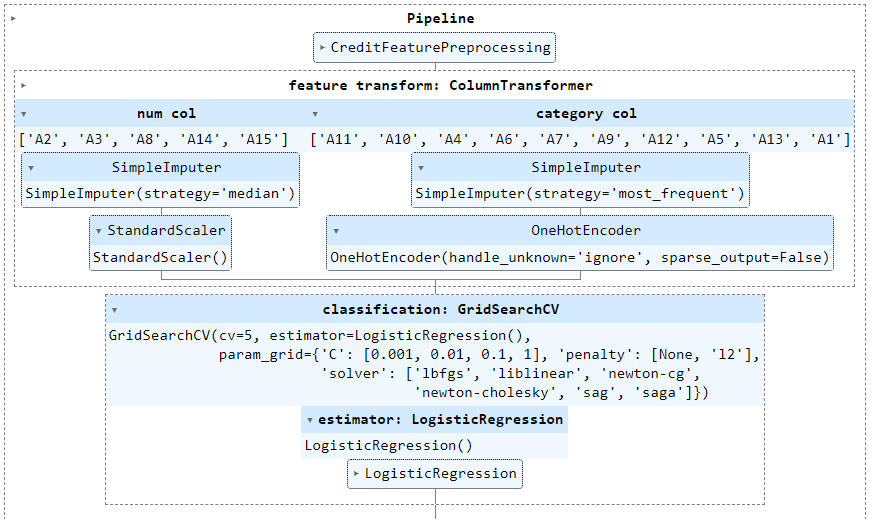

## แยกคอลัมน์ออกเป็นคอลัมน์ตัวเลข และ category

In [ ]:
from sklearn.base import  TransformerMixin
class CreditFeaturePreprocessing(TransformerMixin):
    def __init__(self,num_cols=[]):
        self.num_cols=num_cols

    def fit(self,X,y=None):
        return self

    def transform(self,X, y=None):
        # แทนที่ค่าที่หายไปด้วย np.nan
        X = X.replace('?', np.nan)

        # แปลงข้อมูลเป็น float
        X[self.num_cols]=X[self.num_cols].astype(float)

        return X

In [ ]:
num_cols=['A2','A3','A8','A14','A15']
category_cols=list(set(data.columns)-set(num_cols+['A16']))

In [ ]:
preprocessing = CreditFeaturePreprocessing(num_cols) # เตรียมตัวแปลงชนิด

## การสร้าง Pipeline สำหรับการเตรียมข้อมูลตัวเลข และ Categorical

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

In [ ]:
# ข้อมูลตัวเลข
imp_median = SimpleImputer(missing_values=np.nan, strategy='median')# เตรียมตัวเติมค่าที่หายไปด้วยค่ามัธยฐาน (median)
z_score = StandardScaler()# เตรียมตัวปรับค่าข้อมูลให้แต่ละคอลัมน์มีค่าเฉลี่ยเท่ากันเป็น 0 และ SD เป็น 1
num_preprocessing=Pipeline(steps=[
    ('missing value imputer', imp_median), # นำตัวเติมค่าที่หายไปด้วยค่ามัธยฐาน (median) ใส่ใน pipeline
    ('Z-score', z_score)# นำตัวปรับค่าข้อมูลให้แต่ละคอลัมน์มีค่าเฉลี่ยเท่ากันเป็น 0 และ SD เป็น 1 ใส่ใน pipeline
])

In [ ]:
# ข้อมูล category
imp_mode = SimpleImputer(missing_values=np.nan, strategy='most_frequent')# เตรียมตัวเติมค่าที่หายไปด้วยค่าฐานนิยม (mode)
one_hot = OneHotEncoder(sparse_output=False, handle_unknown='ignore')# เตรียมตัวแปลงข้อมูลเป็น One-Hot Encoding (!ชวนคิด ทำไมต้อง handle_unknown='ignore')
cat_preprocessing=Pipeline(steps=[
    ('missing value imputer', imp_mode),# นำตัวเติมค่าที่หายไปด้วยค่าฐานนิยม (mode) ใส่ใน pipeline
    ('one-hot', one_hot)# นำตัวแปลงข้อมูลแบบ One-Hot Encoding ใส่ใน pipeline
])

In [ ]:
from sklearn.compose import ColumnTransformer
# สร้าง ColumnTransformer เพื่อจัดการกับการแปลงข้อมูลที่แตกต่างกัน
feature_transform = ColumnTransformer([
  ('number preprocessing', num_preprocessing, num_cols),# ใช้ pipeline num_preprocessing สำหรับคอลัมน์ตัวเลข
  ('category preprocessing', cat_preprocessing, category_cols)# ใช้ pipeline cat_preprocessing สำหรับคอลัมน์ Categorical
])
# have an pass trough

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
# กำหนด parameter grid สำหรับ GridSearchCV
param_grid = {
    'penalty': [None, 'l2'],
    'C': [0.001, 0.01, 0.1, 1],
    'solver': ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga']
}

# สร้าง GridSearchCV object
grid_search = GridSearchCV(LogisticRegression(), param_grid, cv=5)

In [ ]:
# สรา้ง pipeline โดยการรวมขั้นตอนทั้งหมดไว้ที่เดียว
model=Pipeline(steps=[
    ('preprocessing', preprocessing),# preprocesing
    ('feature preprocessing', feature_transform),# data transformation
    ('classification', grid_search)# classification
])
model

Pipeline(steps=[('preprocessing',
                 <__main__.CreditFeaturePreprocessing object at 0x793ba0e43fd0>),
                ('feature preprocessing',
                 ColumnTransformer(transformers=[('number preprocessing',
                                                  Pipeline(steps=[('missing '
                                                                   'value '
                                                                   'imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('Z-score',
                                                                   StandardScaler())]),
                                                  ['A2', 'A3', 'A8', 'A14',
                                                   'A15']),
                                                 ('category preprocessing',
                                                  Pipeline(steps...
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('one-hot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['A1', 'A9', 'A6', 'A10',
                                                   'A12', 'A13', 'A4', 'A11',
                                                   'A5', 'A7'])])),
                ('classification',
                 GridSearchCV(cv=5, estimator=LogisticRegression(),
                              param_grid={'C': [0.001, 0.01, 0.1, 1],
                                          'penalty': [None, 'l2'],
                                          'solver': ['lbfgs', 'liblinear',
                                                     'newton-cg',
                                                     'newton-cholesky', 'sag',
                                                     'saga']}))])

# ใช้งาน

In [ ]:
data_path='https://archive.ics.uci.edu/ml/machine-learning-databases/credit-screening/crx.data'
data=pd.read_csv(data_path,names=['A'+str(i) for i in range(1,17)])

In [ ]:
# prompt: train validation and test split

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

X = data.drop('A16', axis=1)
y = data['A16'].values

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# prompt: turn off warning
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# train
model.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 <__main__.CreditFeaturePreprocessing object at 0x793ba0e43fd0>),
                ('feature preprocessing',
                 ColumnTransformer(transformers=[('number preprocessing',
                                                  Pipeline(steps=[('missing '
                                                                   'value '
                                                                   'imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('Z-score',
                                                                   StandardScaler())]),
                                                  ['A2', 'A3', 'A8', 'A14',
                                                   'A15']),
                                                 ('category preprocessing',
                                                  Pipeline(steps...
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('one-hot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['A1', 'A9', 'A6', 'A10',
                                                   'A12', 'A13', 'A4', 'A11',
                                                   'A5', 'A7'])])),
                ('classification',
                 GridSearchCV(cv=5, estimator=LogisticRegression(),
                              param_grid={'C': [0.001, 0.01, 0.1, 1],
                                          'penalty': [None, 'l2'],
                                          'solver': ['lbfgs', 'liblinear',
                                                     'newton-cg',
                                                     'newton-cholesky', 'sag',
                                                     'saga']}))])

In [ ]:
y_pred = model.predict(X_test)

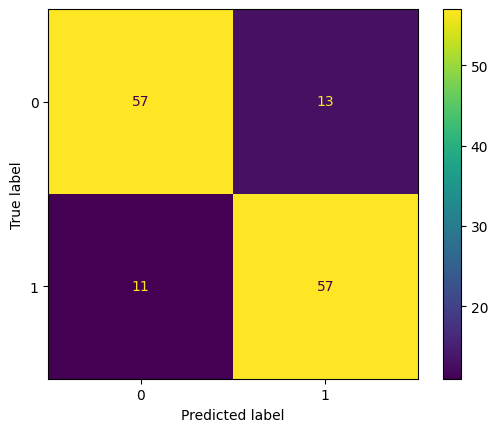

In [ ]:
# prompt: compute confusion matrix and show
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model.classes_)
disp.plot()


In [ ]:
# prompt: print performance, precision recall f1 acc

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.84      0.81      0.83        70
           1       0.81      0.84      0.83        68

    accuracy                           0.83       138
   macro avg       0.83      0.83      0.83       138
weighted avg       0.83      0.83      0.83       138



# Workshop 03 Hands On

สร้าง prediction model โดยใช้ข้อมูลที่กำหนดให้นี้

https://github.com/praisan/hello-world/raw/master/german_credit_data.csv

In [ ]:
import pandas as pd
df = pd.read_csv('https://github.com/praisan/hello-world/raw/master/german_credit_data.csv')
df

,Unnamed: 0,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,2,49,male,1,own,little,NaN,2096,12,education,good
3,3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,4,53,male,2,free,little,little,4870,24,car,bad
...,...,...,...,...,...,...,...,...,...,...,...
995,995,31,female,1,own,little,NaN,1736,12,furniture/equipment,good
996,996,40,male,3,own,little,little,3857,30,car,good
997,997,38,male,2,own,little,NaN,804,12,radio/TV,good
998,998,23,male,2,free,little,little,1845,45,radio/TV,bad


In [ ]:
from sklearn.preprocessing import LabelEncoder
X = df.drop(['Unnamed: 0','Risk'], axis=1)
y = df['Risk'].values

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
dfSummary(df)

No,Variable,Stats / Values,Freqs / (% of Valid),Graph,Missing
1,Unnamed: 0[int64],Mean (sd) : 499.5 (288.8)min < med < max:0.0 < 499.5 < 999.0IQR (CV) : 499.5 (1.7),"1,000 distinct values","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjcuMSwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/bCgiHAAAACXBIWXMAAA9hAAAPYQGoP6dpAAABxklEQVR4nO3XQU7CYBBA4fkbJSCkDSHCAbwBSw7hYT0EJ2DhxhU7EtKUUDEarCcAKTXqS963baczixcSUtM0If132V8fIF3i5rsXUkqDiOhd+f0sIj6vnO06T91Nvbvr/HvTNIdTD8+GmlIaTCaTxzzPx223Ho/H27quH0aj0UuWZR+/OU/dTb37J+Z3u12ZUno6Fet3v6i9PM/Hi8XiUBTFW5vF6/V6vFqt7ufz+fNsNivbzHadp+6m3t11vqqq/nK5HG+3215EXBVqREQURfE2nU5f2ywvy3IQETEcDlvPdp2n7qbe/RPzETE499A/U0IwVCEYqhAMVQiGKgRDFYKhCsFQhWCoQjBUIRiqEAxVCIYqBEMVgqEKwVCFYKhCMFQhGKoQDFUIhioEQxWCoQrBUIVgqEIwVCEYqhAMVQiGKgRDFYKhCsFQhWCoQjBUIRiqEAxVCIYqBEMVgqEKwVCFYKhCMFQhGKoQDFUIhioEQxWCoQrBUIVgqEIwVCEYqhAMVQiGKgRDFYKhCsFQhWCoQjBUIRiqEAxVCIYqBEMVgqEK4eaSl6qq6rf98H6/70dE1HXd32w2d785T91Nvbvr/CV9fQGSljnmc7n3zQAAAABJRU5ErkJggg=="">",0(0.0%)
2,Age[int64],Mean (sd) : 35.5 (11.4)min < med < max:19.0 < 33.0 < 75.0IQR (CV) : 15.0 (3.1),53 distinct values,"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjcuMSwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/bCgiHAAAACXBIWXMAAA9hAAAPYQGoP6dpAAACoElEQVR4nO3cMY7aQBSA4TdhIQYiG0QEHS1FpBSUHCKHzRGCxAEQN6BDMsgIBwdjSJUiCsuCx5PMc/6vH7C0v4xnvDPmer0K4Lt3//oCgEe8uPxwY0xbRFoWH3G6Xq/Hqq4HejkL1RjTHgwGX8Iw7Jf9jP1+vzPGfCVWuLyjtsIw7M9ms2MURdmzg5MkCRaLRT+O45aIEOp/zulPv4hIFEXZcDj8XnJ4u9KLgVpMpqACoUIFQoUKhAoVCBUqECpUIFSoQKhQgVChAqFCBUKFCoQKFQgVKhAqVCBUqECoUIFQoQKhQgXnW1FsFEXRFJHQGFNmODtYa8TbUNM0beZ5/nk8HjcajcbTmwPZwVov3oZ6Op1egiDoTKfTbDQa7Z4Zyw7W+vE21F+63W7ZXazsYK0RJlNQgVChgvc//WVZrhiIsGrglTdDtTjoLLxcLs0S46zZrhiIsGrgm7uh2hx0lud5UBTFpyzLvolI2SN9SrFZMRBh1cBHb91RSx90tl6v+6vVqnM+nxsW12fFYsVAhFUDrzz0jFrmoLPdbscfGpVh1g8VCBUqECpUIFSoQKhQgVChAqFCBUKFCoQKFQgVKhAqVKjt/6PaYgesXwj1BnbA+odQb2AHrH8I9Q52wPqDyRRU4I7qABOx6hFqxZiIuUGoFWMi5gahOsJErFpMpqACoUIFQoUKPKN6hjOzbiNUj3Bm1usI1SOcmfU6QvUQZ2b9iVBrpq6vbwm1Rur8+pZQa8T29e18Ph/GcfzRGLMvewmuIifUGirzjOv7igOhQkT8X3EgVPzGZsWhKIpQHE3kCBWVcD2ReyjUJEmCZ7/4cDgEIiJpmgabzabzN8dr/W6t1y0ist1uPwRB0JlMJqbX6/14ZuzxeHy/XC7vPjb8BNLGyIcxFrFGAAAAAElFTkSuQmCC"">",0(0.0%)
3,Sex[object],1. male2. female,690 (69.0%)310 (31.0%),"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAAAuCAYAAAA/ZmtKAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjcuMSwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/bCgiHAAAACXBIWXMAAA9hAAAPYQGoP6dpAAABPElEQVR4nO3bQWrDMBRF0a9iQjORMAYvxovoYrsI7cYYa5CETJRBx21KAk98654VfMhNIMYv1FoNUAhmdjazU+tD8C/3Wuu19RGvGqZp+ooxjq0PwXOllC2E8O01uCHGOC7Lck0p3Vofg9/t+/6Zcx7XdT2Zmc/YzMxSSrd5ni+tj8FT59YHvOOj9QHoB7FBhtggQ2yQITbIEBtkiA0yxAYZYoMMsUGG2CBDbJAhNsgQG2SIDTKD2c+Lea0Pwd+O8BkNpZQt5zya8xfzelBK2czs3vqOVzF48cX14CUw5YPKEX7ZXH/be+J+yud93tYT11O+I8zbenKEKR//op3goS5kiA0yxAYZYoMMsUGG2CBDbJAhNsgQG2SIDTLEBhligwyxQYbYIENskHE95fN6d6/cT/m8z9t6wuAFMg8KW2rft2WGMwAAAABJRU5ErkJggg=="">",0(0.0%)
4,Job[int64],1. 22. 13. 34. 0,630 (63.0%)200 (20.0%)148 (14.8%)22 (2.2%),"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAABcCAYAAAB5jMeAAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjcuMSwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/bCgiHAAAACXBIWXMAAA9hAAAPYQGoP6dpAAAB+UlEQVR4nO3dQWrbQACF4VEwodlIGIMPo0P0sD2EbmOMtahDNuqiaex6P2+C5/t23g3mR0ZCDw/bthVIeGl9APohNmKGUspbKeW19UEoH9u2XVsfoqbd4XD4OY7jvvVBereu63kYhl/PHNxuHMf9PM/XaZreWx+mV5fL5ceyLPvT6fRaSnne2EopZZqm9+Px+Lv1YTr31voAtblBIEZsxIiNGLERIzZixEaM2IgRGzFiI0ZsxIiNGLERIzZidqX8fcWl9UF61sv3v1vX9bwsy7508IrLd7au67mU8tH6HDV5Lfz7ePrXwgdTPlLcIBDT+mf06X86uGm6ruphUcRNs3VVL4siblqvqzxu6YgbBGLERozYiBEbMWIjRmzEiI0YsREjNmLERozYiBEbMWIjRmzENJvy9TJf46bplK+H+Ro3NgjEmPIRU/vK5srFl6rrKusp7lVbV1lP8aj2usp6ii8e6hIjNmLERozYiBEbMWIjRmzEiI0YsREjNmLERozYiBEbMWIjptq6ynqKR1XXVdZT3LNBIMa6ipjHK5srEdX8t66yhqKml3/rqnmer5/R+aNbqvhaV31+toaiGg91iREbMWIjRmzEiI0YsREjNmLERozYiBEbMWIjRmzEiI0YsRHT7L+r6M/9usoaiqpsEIixriLGDQIxfwBH1MxaCfmrvwAAAABJRU5ErkJggg

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Unnamed: 0        1000 non-null   int64 
 1   Age               1000 non-null   int64 
 2   Sex               1000 non-null   object
 3   Job               1000 non-null   int64 
 4   Housing           1000 non-null   object
 5   Saving accounts   817 non-null    object
 6   Checking account  606 non-null    object
 7   Credit amount     1000 non-null   int64 
 8   Duration          1000 non-null   int64 
 9   Purpose           1000 non-null   object
 10  Risk              1000 non-null   object
dtypes: int64(5), object(6)
memory usage: 86.1+ KB


In [ ]:
num_cols=['Age', 'Job', 'Credit amount', 'Duration']
category_cols=list(set(df.columns)-set(num_cols+['Risk', 'Unnamed: 0']))
# category_cols

In [ ]:
# ข้อมูลตัวเลข
imp_median = SimpleImputer(missing_values=np.nan, strategy='median')# เตรียมตัวเติมค่าที่หายไปด้วยค่ามัธยฐาน (median)
z_score = StandardScaler()# เตรียมตัวปรับค่าข้อมูลให้แต่ละคอลัมน์มีค่าเฉลี่ยเท่ากันเป็น 0 และ SD เป็น 1
num_preprocessing=Pipeline(steps=[
    ('missing value imputer', imp_median), # นำตัวเติมค่าที่หายไปด้วยค่ามัธยฐาน (median) ใส่ใน pipeline
    ('Z-score', z_score)# นำตัวปรับค่าข้อมูลให้แต่ละคอลัมน์มีค่าเฉลี่ยเท่ากันเป็น 0 และ SD เป็น 1 ใส่ใน pipeline
])

# ข้อมูล category
imp_mode = SimpleImputer(missing_values=np.nan, strategy='most_frequent')# เตรียมตัวเติมค่าที่หายไปด้วยค่าฐานนิยม (mode)
one_hot = OneHotEncoder(sparse_output=False, handle_unknown='ignore')# เตรียมตัวแปลงข้อมูลเป็น One-Hot Encoding (!ชวนคิด ทำไมต้อง handle_unknown='ignore')
cat_preprocessing=Pipeline(steps=[
    ('missing value imputer', imp_mode),# นำตัวเติมค่าที่หายไปด้วยค่าฐานนิยม (mode) ใส่ใน pipeline
    ('one-hot', one_hot)# นำตัวแปลงข้อมูลแบบ One-Hot Encoding ใส่ใน pipeline
])

In [ ]:
# สร้าง ColumnTransformer เพื่อจัดการกับการแปลงข้อมูลที่แตกต่างกัน
feature_transform = ColumnTransformer([
  ('number preprocessing', num_preprocessing, num_cols),# ใช้ pipeline num_preprocessing สำหรับคอลัมน์ตัวเลข
  ('category preprocessing', cat_preprocessing, category_cols)# ใช้ pipeline cat_preprocessing สำหรับคอลัมน์ Categorical
])

In [ ]:
# กำหนด parameter grid สำหรับ GridSearchCV
param_grid = {
    'penalty': ['l1', 'l2', 'elasticnet', None],
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'solver': ['lbfgs', 'liblinear', 'newton-cg', 'saga'],
    'max_iter': [100, 200, 500],
    'l1_ratio': [0, 0.5, 1]  # This is only used when penalty is 'elasticnet'
}

# สร้าง GridSearchCV object
grid_search = GridSearchCV(LogisticRegression(), param_grid, cv=5)

In [ ]:
# สรา้ง pipeline โดยการรวมขั้นตอนทั้งหมดไว้ที่เดียว
model=Pipeline(steps=[
    ('feature preprocessing', feature_transform),# data transformation
    ('classification', grid_search)# classification
])
# model

In [ ]:
# train
model.fit(X_train, y_train)

Pipeline(steps=[('feature preprocessing',
                 ColumnTransformer(transformers=[('number preprocessing',
                                                  Pipeline(steps=[('missing '
                                                                   'value '
                                                                   'imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('Z-score',
                                                                   StandardScaler())]),
                                                  ['Age', 'Job',
                                                   'Credit amount',
                                                   'Duration']),
                                                 ('category preprocessing',
                                                  Pipeline(steps=[('missing '
                                                                   'value '
                                                                   'imputer',
                                                                   SimpleImputer(strategy='most_frequent'...
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['Sex', 'Housing',
                                                   'Checking account',
                                                   'Saving accounts',
                                                   'Purpose'])])),
                ('classification',
                 GridSearchCV(cv=5, estimator=LogisticRegression(),
                              param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100],
                                          'l1_ratio': [0, 0.5, 1],
                                          'max_iter': [100, 200, 500],
                                          'penalty': ['l1', 'l2', 'elasticnet',
                                                      None],
                                          'solver': ['lbfgs', 'liblinear',
                                                     'newton-cg', 'saga']}))])

In [ ]:
model.steps[1][1].best_params_

{'C': 1, 'l1_ratio': 0, 'max_iter': 100, 'penalty': 'l2', 'solver': 'lbfgs'}

In [ ]:
model=Pipeline(steps=[
    ('feature preprocessing', feature_transform),# data transformation
    ('classification', LogisticRegression(C=1, max_iter=100, penalty='l2', solver='lbfgs'))# classification
])
model.fit(X_train, y_train)

Pipeline(steps=[('feature preprocessing',
                 ColumnTransformer(transformers=[('number preprocessing',
                                                  Pipeline(steps=[('missing '
                                                                   'value '
                                                                   'imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('Z-score',
                                                                   StandardScaler())]),
                                                  ['Age', 'Job',
                                                   'Credit amount',
                                                   'Duration']),
                                                 ('category preprocessing',
                                                  Pipeline(steps=[('missing '
                                                                   'value '
                                                                   'imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('one-hot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['Sex', 'Housing',
                                                   'Checking account',
                                                   'Saving accounts',
                                                   'Purpose'])])),
                ('classification', LogisticRegression(C=1))])

In [ ]:
y_pred = model.predict(X_test)

              precision    recall  f1-score   support

           0       0.48      0.22      0.30        59
           1       0.73      0.90      0.81       141

    accuracy                           0.70       200
   macro avg       0.61      0.56      0.56       200
weighted avg       0.66      0.70      0.66       200



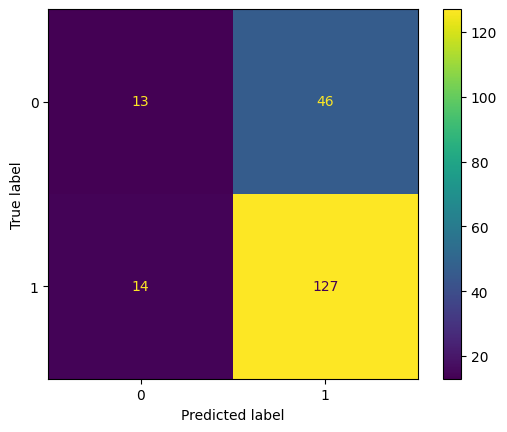

In [ ]:

print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model.classes_)
disp.plot()